In [2]:
from google.colab import drive
# this mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'dlvis2020-entregables/assignment1_colab/cs231n/'
FOLDERNAME = 'codigoPFC/deepCloudGit/deepCloud/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
!ls
%cd "drive/MyDrive/codigoPFC/deepCloudGit/deepCloud"
!ls

Mounted at /content/drive
drive  sample_data
/content/drive/MyDrive/codigoPFC/deepCloudGit/deepCloud
data			       nb-module-testing.ipynb
les-prono		       nb-moving-mnist.ipynb
misc			       nb-outlier-finder.ipynb
nb-andres.ipynb		       nb-train-optuna.ipynb
nb-data-exp-on-server.ipynb    prueba
nb-demo.ipynb		       README.md
nb-evaluate-model-cloud.ipynb  reports
nb-franco.ipynb		       src
nb-load-images.ipynb


In [3]:
!pip install piqa
!pip install timezonefinder

In [4]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import timeit

from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoDataset
from src.data import MontevideoFoldersDataset

## TensorBoard Test

In [5]:
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.utils.data import DataLoader, random_split
from torch import optim
import torch.nn as nn
from piqa import SSIM , MS_SSIM
from src.dl_models.unet import UNet
from tqdm import tqdm
import random

In [6]:
#SETUP
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [7]:
model = UNet(n_channels=3,n_classes=1,bilinear=True).to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('El modelo tiene', params, 'parametros entrenables')

El modelo tiene 17267393 parametros entrenables


In [8]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [10]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

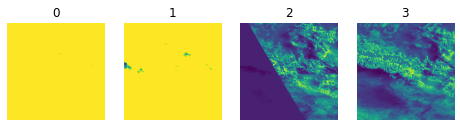

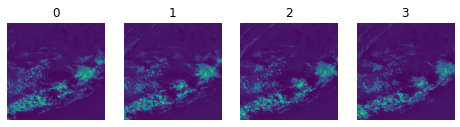

In [22]:
def plot_sequence(seq, idxs):
    seq = seq.squeeze()
    C, _, _ = seq.shape

    columns = C
    rows = 1
    _, axes = plt.subplots(rows, columns, figsize=(2*C, 2*C))

    for idx, ax in enumerate(axes):
        img = seq[idx]

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(idxs[idx])
    plt.show()

batch_size = 1
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/validation/' , path_sequence_csv = 'data/mvd/val_sequences.csv',
                                    in_channel = 3,out_channel=1, shuffle = False)

val_loader = DataLoader(val_mvd, batch_size=batch_size, shuffle=True, num_workers=2)

for idx, (in_frames, out_frames) in enumerate(val_loader):
  sequence = torch.cat((in_frames, out_frames), dim=1).squeeze().numpy()
  plot_sequence(sequence, np.arange(0, 4))
  break

for idx, (in_frames, out_frames) in enumerate(val_loader):
  sequence = torch.cat((in_frames, out_frames), dim=1).squeeze().numpy()
  plot_sequence(sequence, np.arange(0, 4))
  break

In [24]:
len(val_mvd)

2886

In [ ]:
torch.cuda.empty_cache()
model = UNet(n_channels=3,n_classes=1,bilinear=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001,betas = (0.9,0.999),eps=1e-08, weight_decay=0 ,amsgrad=False)
criterion = nn.MSELoss()

epochs=1
batch_size = 10
eval_data = 30
losses_val = []
num_val_samples = 10

train_mvd = MontevideoFoldersDataset(path = 'data/mvd/train/' , path_sequence_csv = 'data/mvd/train_sequences.csv',
                                      in_channel = 3,out_channel=1, shuffle = False)

val_mvd = MontevideoFoldersDataset(path = 'data/mvd/validation/' , path_sequence_csv = 'data/mvd/val_sequences.csv',
                                    in_channel = 3,out_channel=1, shuffle = False)

train_dataloader = DataLoader(train_mvd, batch_size=batch_size, shuffle=False, num_workers=2)
val_dataloader = DataLoader(val_mvd, batch_size=batch_size, shuffle=False, num_workers=2)
  
print_every = 25

start = time.perf_counter()
for id, (in_frames,out_frames) in enumerate(train_dataloader):
  model.train(True) #put model in trainning mode
  in_frames = in_frames.to(device, dtype=torch.float32)
  out_frames = out_frames.to(device, dtype=torch.float32)

  frames_pred = model(in_frames)
  loss = criterion(frames_pred, out_frames)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if id % print_every == 0:
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
      for idx, (in_frames, out_frames) in enumerate(val_dataloader):
        # cargar datos de evaluacion
        in_frames = in_frames.to(device, dtype=torch.float32)
        out_frames = out_frames.to(device, dtype=torch.float32)

        frames_pred = model(in_frames)

        loss_val = criterion(frames_pred, out_frames)
        losses_val.append(loss_val.item())
        if idx == num_val_samples:
          break

    end = time.perf_counter()
    print('Iteration',id ,'/',int(len(train_mvd)/batch_size) , ',train_loss = %.4f' %loss.item(), ',val_loss = %.4f' % np.sum(losses_val), ',Iteration time = %.2f' %((end-start)/print_every), 's'  )
    start = time.perf_counter()
    losses_val = []


Iteration 0 / 1682 ,train_loss = 634.4979 ,val_loss = 14548.9195 ,Iteration time = 8.52 s
Iteration 25 / 1682 ,train_loss = 231.8059 ,val_loss = 4134.6051 ,Iteration time = 55.07 s
